Methods and Experiments
=============

1. [Experimental Setup](#sec1)
 1. [Basic Definitions](#sec1.1)
1. [Computation Steps](#sec2)
1. [Compute Experimental Data](#sec3)
 1. [Load Trajectory Data](#sec3.1)
 1. [Compute POI Info](#sec3.2)
 1. [Construct Travelling Sequences](#sec3.3)
 1. [Choose Travelling Sequences for experiment](#sec3.4)
 1. [Compute transition matrix using training set](#sec3.5)
 1. [Compute POI popularity and user interest using training set](#sec3.6)
 1. [Enumerate Trajectories with length {3, 4, 5}](#sec3.7)
 1. [Compute Features (scores) for each enumerated sequence](#sec3.8)
1. [Experiments with training set](#sec4)
 1. [Experiment with random weights](#sec4.1)
 1. [Experiment with single feature](#sec4.2)
 1. [Search weights using coordinate-wise grid search](#sec4.3)
1. [Apply search results to testing set](#sec5)

<a id='sec1'></a>

## 1. Experimental Setup

Enumerate all trajectories for each user given the trajectory length (e.g. 3, 4, 5) and the (start, end) POIs.

For each trajectory, compute a score based on the features below:
 * User Interest (time-based)
 * User Interest (frequency-based)
 * POI Popularity
 * Travelling Cost (distance/time) 
 * Trajectory probability based on the transition probabilities between different POI categories and the following rules for choosing a specific POI within certain category:
  * The Nearest Neighbor of the current POI
  * The most Popular POI
  * A random POI choosing with probability proportional to the reciprocal of its distance to current POI
  * A random POI choosing with probability proportional to its popularity

To avoid numerical underflow, use the log of of probabilities instead of the probabilities themselves, 
to avoid zero probabilities, add a smooth value $\epsilon = 10^{-12}$ for each probability.

Plot the scores of generated and actual trajectories for each (user, trajectoryLength, startPOI, endPOI) tuple with some degree of transparency (alpha).

Recommend trajectory with the highest score and measure the performance of recommendation using recall, precision and F1-score.

Optimise parameters in the score function by learning, in this specific case, the cost function could be based on recall, precision or F1-score, we can also control the estimation of transition matrix.

<a id='sec1.1'></a>

### 1.1 Basic definitions

For user $u$ and POI $p$, define

* **Travel History**: 
\begin{equation*}
S_u = \{(p_1, t_{p_1}^a, t_{p_1}^d), \dots, (p_n, t_{p_n}^a, t_{p_n}^d)\}
\end{equation*}
where $t_{p_i}^a$ is the arrival time and $t_{p_i}^d$ the departure time of user $u$ at POI $p_i$

* **Travel Sequences**: split $S_u$ if
\begin{equation*}
|t_{p_i}^d - t_{p_{i+1}}^a| > \tau ~(\text{e.g.}~ \tau = 8 ~\text{hours})
\end{equation*}

* **POI Popularity**:
\begin{equation*}
Pop(p) = \sum_{u \in U} \sum_{p_i \in S_u} \delta(p_i == p)
\end{equation*}

* **Average POI Visit Duration**: 
\begin{equation*}
\bar{V}(p) = \frac{1}{N} \sum_{u \in U} \sum_{p_i \in S_u} (t_{p_i}^d - t_{p_i}^a) \delta(p_i == p)
\end{equation*}
where $N$ is \#visits of POI $p$ by all users
      
Define the interest of user $u$ in POI category $c$ as

* **Time based User Interest**:
\begin{equation*}
Int^{Time}(u, c) = \sum_{p_i \in S_u} \frac{(t_{p_i}^d - t_{p_i}^a)}{\bar{V}(p_i)} \delta(Cat_{p_i} == c)
\end{equation*}
where $Cat_{p_i}$ is the category of POI $p_i$

* **Frequency based User Interest**:
\begin{equation*}
Int^{Freq}(u, c) = \sum_{p_i \in S_u} \delta(Cat_{p_i} == c)
\end{equation*}

<a id='sec2'></a>

## 2. Computation Steps

1. Split actual trajectories input two parts, one for training, the other for testing.  
   Concretely, For each user, consider all the trajectories with length `3`, `4` and `5`, pick one for testing set and put all others into training set.
   
1. Use trajectories in training set to compute (MLE) a transition matrix where element `[i, j]` denotes the transition probability from POI category `i` to POI category `j`.

1. For each trajectory $T$ in training set, enumerate all possible trajectories that satisfy the following requirements:
 * The trajectory length is the same as that of $T$
 * The start/end POI are the same as those of $T$
 * No sub-tour exists
 
1. Compute the `8` scores [described above](#sec1) as features, rescale each score into range `[-1, 1]`, compute the weighted sum of these score to get a single score.  
~~(weights are normalised so that they are in range `[0, 1]` and their sum is `1`)~~  
(*the values in parameter/weight vector are now drawn from range `[-1, 1]`, and the sum now doesn't necessarily to be 1.*)
 
1. Choose the trajectory with the highest score $T^*$ and compute F1 score as follows:  
 * recall = $\frac{|T^* \cap T|}{|T|}$  
 * precision = $\frac{|T^* \cap T|}{T^*}$  
 * F1-score = $\frac{2 \times \text{recall} \times \text{precision}}{\text{recall} + \text{precision}}$
 
1. Compute the mean F1 score for all trajectory $T$ in the training set.

1. Use coordinate-wise grid search to find an good weight vector such that the mean F1 score is as large as possible.

<a id='sec3'></a>

## 3. Compute Experimental Data

**NOTE: Before running this notebook, please run script `src/ijcai15_setup.py` to setup data properly.**

<a id='sec3.1'></a>

### 3.1 Load Trajectory Data

In [343]:
%matplotlib inline

import os
import math
import random
import pickle
import pandas as pd
import numpy as np
import numpy.matlib
from datetime import datetime
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [344]:
nfeatures = 8 # number of features
EPS = 1e-12 # smooth, deal with 0 probability
random.seed(123456789) # control random choice when splitting training/testing set

In [345]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [346]:
suffix = fvisit.split('-')[-1].split('.')[0]

In [347]:
fpoi = os.path.join(data_dir, 'poi-' + suffix + '.csv')  
fseq = os.path.join(data_dir, 'seq-' + suffix + '.csv')
ftrain = os.path.join(data_dir, 'trainset-' + suffix + '.pkl')
ftest  = os.path.join(data_dir, 'testset-' + suffix + '.pkl')
ffeatures_train = os.path.join(data_dir, 'featuresTrain-' + suffix + '.pkl')
ffeatures_test  = os.path.join(data_dir, 'featuresTest-' + suffix + '.pkl')

In [348]:
visits = pd.read_csv(fvisit, sep=';')
visits.head()

,photoID,userID,dateTaken,poiID,poiTheme,poiFreq,seqID
0,7941504100,10007579@N00,1346844688,30,Structure,1538,1
1,4886005532,10012675@N05,1142731848,6,Cultural,986,2
2,4886006468,10012675@N05,1142732248,6,Cultural,986,2
3,4885404441,10012675@N05,1142732373,6,Cultural,986,2
4,4886008334,10012675@N05,1142732445,6,Cultural,986,2


In [349]:
coords = pd.read_csv(fcoord, sep=';')
coords.head()

,photoID,photoLon,photoLat
0,7941504100,-79.380844,43.645641
1,4886005532,-79.391525,43.654335
2,4886006468,-79.391525,43.654335
3,4885404441,-79.391525,43.654335
4,4886008334,-79.391525,43.654335


In [350]:
# merge data frames according to column 'photoID'
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID')
traj.head()

,photoID,userID,dateTaken,poiID,poiTheme,poiFreq,seqID,photoLon,photoLat
0,7941504100,10007579@N00,1346844688,30,Structure,1538,1,-79.380844,43.645641
1,4886005532,10012675@N05,1142731848,6,Cultural,986,2,-79.391525,43.654335
2,4886006468,10012675@N05,1142732248,6,Cultural,986,2,-79.391525,43.654335
3,4885404441,10012675@N05,1142732373,6,Cultural,986,2,-79.391525,43.654335
4,4886008334,10012675@N05,1142732445,6,Cultural,986,2,-79.391525,43.654335


In [351]:
pd.DataFrame([traj[['photoLon', 'photoLat']].min(), traj[['photoLon', 'photoLat']].max(), \
             traj[['photoLon', 'photoLat']].max() - traj[['photoLon', 'photoLat']].min()], \
             index = ['min', 'max', 'range'])

,photoLon,photoLat
min,-79.465088,43.618523
max,-79.180336,43.822018
range,0.284752,0.203495


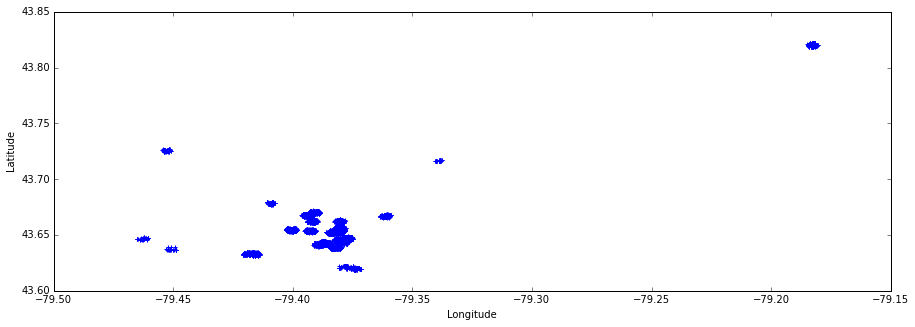

In [352]:
plt.figure(figsize=[15, 5])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(traj['photoLon'], traj['photoLat'], marker='+')

In [353]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame([num_photo, num_user, num_poi, num_seq, num_photo/num_user, num_seq/num_user], \
             index = ['#photo', '#user', '#poi', '#seq', '#photo/user', '#seq/user'], columns=['Edinburgh'])

,Edinburgh
#photo,39419.000000
#user,1395.000000
#poi,29.000000
#seq,6057.000000
#photo/user,28.257348
#seq/user,4.341935


<a id='sec3.2'></a>

### 3.2 Compute POI Info

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [354]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)
#poi_coords

Extract POI category and visiting frequency.

In [355]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)
#poi_catfreq

In [356]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
#poi_all

Save POI info to file.

In [357]:
poi_all.to_csv(fpoi, index=True)
#poi_all2 = pd.read_csv(fpoi, index_col=0)
#poi_all2

<a id='sec3.3'></a>

### 3.3 Construct Travelling Sequences

In [358]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy()\
          .groupby(['userID', 'seqID', 'poiID']).agg([np.min, np.max])
#seq_all.head()

In [359]:
seq_all.columns = seq_all.columns.droplevel()
seq_all.head()

amin        amax
userID       seqID poiID                        
10007579@N00 1     30     1346844688  1346844688
10012675@N05 2     6      1142731848  1142732445
             3     6      1142916492  1142916492
             4     13     1319327174  1319332848
10014440@N06 5     24     1196128621  1196128878

In [360]:
seq_all.reset_index(inplace=True)
seq_all.head()

,userID,seqID,poiID,amin,amax
0,10007579@N00,1,30,1346844688,1346844688
1,10012675@N05,2,6,1142731848,1142732445
2,10012675@N05,3,6,1142916492,1142916492
3,10012675@N05,4,13,1319327174,1319332848
4,10014440@N06,5,24,1196128621,1196128878


In [361]:
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
#print('Found %d sequences' % len(seq_all))
#pickle.dump(seq_all, open('all_trajectories.pkl', 'bw'))
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,0
1,10012675@N05,2,6,1142731848,1142732445,597
2,10012675@N05,3,6,1142916492,1142916492,0
3,10012675@N05,4,13,1319327174,1319332848,5674
4,10014440@N06,5,24,1196128621,1196128878,257


Save travelling sequences to file.

In [362]:
seq_all.to_csv(fseq, index=False)
#seq_all2 = pd.read_csv(fseq)
#seq_all2.head()

In [363]:
#seq_all = pickle.load(open('all_trajectories.pkl'))
seq_user = seq_all[['seqID', 'userID']].copy()
seq_user = seq_user.groupby('seqID').first()
#type(seq_user)
#seq_user.loc[1].iloc[0]
#seq_user.reset_index(inplace=True)
#seq_user.set_index('seqID', inplace=True)
seq_user.head()

,userID
seqID,
1,10007579@N00
2,10012675@N05
3,10012675@N05
4,10012675@N05
5,10014440@N06


<a id='sec3.4'></a>

### 3.4 Choose Travelling Sequences for experiment

Trajectories with length `{3, 4, 5}` are used in our experiment.

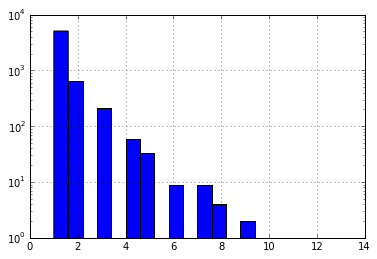

In [364]:
seq_len = seq_all[['userID', 'seqID', 'poiID']].copy()
seq_len = seq_len.groupby(['userID', 'seqID']).agg(np.size)
seq_len.reset_index(inplace=True)
seq_len.rename(columns={'poiID':'seqLen'}, inplace=True)
#seq_len.head()
ax = seq_len['seqLen'].hist(bins=20)
ax.set_yscale('log')

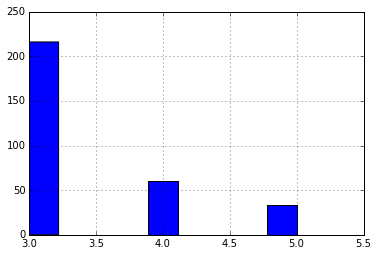

In [365]:
seq_345 = seq_len[seq_len['seqLen'].isin({3, 4, 5})]
seq_345['seqLen'].hist(bins=9)

Split travelling sequences into training set and testing set using leave-one-out for each user.  
*For testing purpose, users with less than two travelling sequences are not considered in this experiment.*

In [366]:
train_set = []
test_set = []

In [367]:
user_seqs = seq_345[['userID', 'seqID']].groupby('userID')

In [368]:
for user, indices in user_seqs.groups.items():
    if len(indices) < 2: continue
    idx = random.choice(indices)
    test_set.append(seq_345.loc[idx, 'seqID'])
    train_set.extend([seq_345.loc[x, 'seqID'] for x in indices if x != idx])

#seq in trainset: 128
#seq in testset: 41


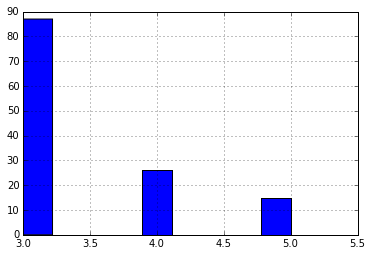

In [369]:
print('#seq in trainset:', len(train_set))
print('#seq in testset:', len(test_set))
seq_345[seq_345['seqID'].isin(train_set)]['seqLen'].hist(bins=9)
#data = np.array(seqs1['seqLen'])
#hist, bins = np.histogram(data, bins=3)
#print(hist)

#### Sanity check: the total number of travelling sequences used in experiment.

In [370]:
seq_exp = seq_345[['userID', 'seqID']].copy()
seq_exp = seq_exp.groupby('userID').agg(np.size)
seq_exp.reset_index(inplace=True)
seq_exp.rename(columns={'seqID':'#seq'}, inplace=True)
seq_exp = seq_exp[seq_exp['#seq'] > 1]
print('total #seq for experiment:', seq_exp['#seq'].sum())
#seq_exp.head()

total #seq for experiment: 169


In [371]:
seq_t = seq_345[seq_345['seqID'].isin(train_set)]
nseq3 = seq_t[seq_t['seqLen'] == 3].shape[0]
nseq4 = seq_t[seq_t['seqLen'] == 4].shape[0]
nseq5 = seq_t[seq_t['seqLen'] == 5].shape[0]
nseq345 = nseq3 + nseq4 + nseq5
randF1 = (2/3) * (nseq3 / nseq345) + (2/4) * (nseq4 / nseq345) + (2/5) * (nseq5 / nseq345)
print('%d sequences with length 3, %d sequences with length 4, %d sequences with length 5' % (nseq3, nseq4, nseq5))
print('F1-score by random guessing is %.3f' % randF1)

87 sequences with length 3, 26 sequences with length 4, 15 sequences with length 5
F1-score by random guessing is 0.602


Save training/testing set to file.

In [372]:
pickle.dump(train_set, open(ftrain, 'wb'))
pickle.dump(test_set, open(ftest, 'wb'))

<a id='sec3.5'></a>

### 3.5 Compute transition matrix using training set

Compute transition probabilities between different kind of POI categories.

In [373]:
poi_cats = traj['poiTheme'].unique().tolist()
poi_cats.sort()
poi_cats

['Amusement', 'Beach', 'Cultural', 'Shopping', 'Sport', 'Structure']

In [374]:
ncats = len(poi_cats)
trans_mat = pd.DataFrame(data=np.zeros((ncats, ncats), dtype=np.float64), index=poi_cats, columns=poi_cats)
#trans_mat

Count the transition number for each possible transition.

In [375]:
#train_set = [4, 13, 32, 33, 34, 99, 101]
#seq_all[seq_all['seqID'] == train_set[0]]
for seqid in train_set:
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
    for j in range(len(seqi.index)-1):
        idx1 = seqi.index[j]
        idx2 = seqi.index[j+1]
        poi1 = seqi.loc[idx1, 'poiID']
        poi2 = seqi.loc[idx2, 'poiID']
        cat1 = poi_all.loc[poi1, 'poiTheme']
        cat2 = poi_all.loc[poi2, 'poiTheme']
        trans_mat.loc[cat1, cat2] += 1
trans_mat

,Amusement,Beach,Cultural,Shopping,Sport,Structure
Amusement,4,2,3,3,6,2
Beach,2,13,11,24,4,22
Cultural,3,11,4,10,3,20
Shopping,3,28,8,4,4,20
Sport,5,5,4,1,2,6
Structure,3,24,11,25,5,7


Normalise each row to get an estimate of transition probabilities (MLE).

In [376]:
for r in trans_mat.index:
    rowsum = trans_mat.ix[r].sum()
    if rowsum == 0: continue  # deal with lack of data
    for c in trans_mat.columns:
        trans_mat.loc[r, c] /= rowsum
trans_mat

,Amusement,Beach,Cultural,Shopping,Sport,Structure
Amusement,0.200000,0.100000,0.150000,0.150000,0.300000,0.100000
Beach,0.026316,0.171053,0.144737,0.315789,0.052632,0.289474
Cultural,0.058824,0.215686,0.078431,0.196078,0.058824,0.392157
Shopping,0.044776,0.417910,0.119403,0.059701,0.059701,0.298507
Sport,0.217391,0.217391,0.173913,0.043478,0.086957,0.260870
Structure,0.040000,0.320000,0.146667,0.333333,0.066667,0.093333


Compute the log of transition probabilities with smooth factor $\epsilon=10^{-12}$.

In [377]:
log10_trans_mat = np.log10(trans_mat.copy() + EPS)
log10_trans_mat

,Amusement,Beach,Cultural,Shopping,Sport,Structure
Amusement,-0.698970,-1.000000,-0.823909,-0.823909,-0.522879,-1.000000
Beach,-1.579784,-0.766870,-0.839421,-0.500602,-1.278754,-0.538391
Cultural,-1.230449,-0.666177,-1.105510,-0.707570,-1.230449,-0.406540
Shopping,-1.348954,-0.378917,-0.922985,-1.224015,-1.224015,-0.525045
Sport,-0.662758,-0.662758,-0.759668,-1.361728,-1.060698,-0.583577
Structure,-1.397940,-0.494850,-0.833669,-0.477121,-1.176091,-1.029963


<a id='sec3.6'></a>

### 3.6 Compute POI popularity and user interest using training set

Compute average POI visit duration, POI popularity as defined at the [top of the notebook](#sec1.1).

In [378]:
poi_avg_pop = seq_all[seq_all['seqID'].isin(train_set)]
poi_avg_pop = poi_avg_pop[['poiID', 'poiDuration(sec)']].copy()

In [379]:
poi_avg_pop = poi_avg_pop.groupby('poiID').agg([np.mean, np.size])
poi_avg_pop.columns = poi_avg_pop.columns.droplevel()
poi_avg_pop.reset_index(inplace=True)
poi_avg_pop.rename(columns={'mean':'avgDuration(sec)', 'size':'popularity'}, inplace=True)
poi_avg_pop.set_index('poiID', inplace=True)
print('#poi:', poi_avg_pop.shape[0])
if poi_avg_pop.shape[0] < poi_all.shape[0]:
    extra_index = list(set(poi_all.index) - set(poi_avg_pop.index))
    extra_poi = pd.DataFrame(data=np.zeros((len(extra_index), 2), dtype=np.float64), \
                             index=extra_index, columns=['avgDuration(sec)', 'popularity'])
    poi_avg_pop = poi_avg_pop.append(extra_poi)
    print('#poi after extension:', poi_avg_pop.shape[0])
poi_avg_pop

#poi: 23
#poi after extension: 29


,avgDuration(sec),popularity
poiID,,
1,3801.111111,9
2,4688.400000,5
3,1217.909091,11
4,3785.300000,10
6,2811.000000,8
7,4312.400000,40
8,4621.307692,13
11,732.000000,8
13,3643.000000,2


Compute time/frequency based user interest as defined at the 
[top of the notebook](#sec1.1).

In [380]:
user_interest = seq_all[seq_all['seqID'].isin(train_set)]
user_interest = user_interest[['userID', 'poiID', 'poiDuration(sec)']].copy()

In [381]:
user_interest['timeRatio'] = [poi_avg_pop.loc[x, 'avgDuration(sec)'] for x in user_interest['poiID']]
user_interest['timeRatio'] = user_interest['poiDuration(sec)'] / user_interest['timeRatio']
user_interest['poiTheme'] = [poi_all.loc[x, 'poiTheme'] for x in user_interest['poiID']]
user_interest.drop(['poiID', 'poiDuration(sec)'], axis=1, inplace=True)
user_interest = user_interest.groupby(['userID', 'poiTheme']).agg([np.sum, np.size])
user_interest.columns = user_interest.columns.droplevel()
user_interest.rename(columns={'sum':'timeBased', 'size':'freqBased'}, inplace=True)
user_interest.reset_index(inplace=True)
user_interest.set_index(['userID', 'poiTheme'], inplace=True)
user_interest.head()

timeBased  freqBased
userID       poiTheme                       
10502709@N05 Beach       0.954919          1
             Cultural    1.229478          2
             Shopping    6.872732          2
             Structure  14.362567          1
10627620@N06 Beach       0.064388          1

<a id='sec3.7'></a>

### 3.7 Enumerate Trajectories with length {3, 4, 5}

In [382]:
poi_list = poi_all.index.tolist()

In [383]:
def enum_345_seq(seqid_set, poi_list):
    """Enumerate all possible travelling sequences with length {3, 4, 5}"""
    act_seqs = dict()
    enum_seqs = dict()
    
    for seqid in seqid_set:
        seqi = seq_all[seq_all['seqID'] == seqid].copy()
        seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
        act_seqs[seqid] = seqi['poiID'].tolist()
        p0 = seqi.loc[seqi.index[0], 'poiID']
        pN = seqi.loc[seqi.index[-1],'poiID']
    
        # enumerate sequences with length 3
        if seqi.shape[0] == 3:
            enum_seqs[seqid] = [[p0, p, pN] \
                                for p in poi_list if p not in {p0, pN}]
            continue

        # enumerate sequences with length 4
        if seqi.shape[0] == 4:
            enum_seqs[seqid] = [[p0, p1, p2, pN] \
                                for p1 in poi_list if p1 not in {p0, pN} \
                                for p2 in poi_list if p2 not in {p0, p1, pN}]
            continue

        # enumerate sequences with length 5
        if seqi.shape[0] == 5:
            enum_seqs[seqid] = [[p0, p1, p2, p3, pN] \
                                for p1 in poi_list if p1 not in {p0, pN} \
                                for p2 in poi_list if p2 not in {p0, p1, pN} \
                                for p3 in poi_list if p3 not in {p0, p1, p2, pN}]
            continue
    return enum_seqs, act_seqs    

<a id='sec3.8'></a>

### 3.8 Compute Features (scores) for each enumerated sequence

As described at [the top of the notebook](#sec1), features for each trajectory used in this experiment are:
1. total time-based user interest
1. total freq-based user interest
1. total POI popularity
1. total travel distance (without the visit duration time at each POI)
1. features 5 to 8 are trajectory (log) probabilities based on the transition matrix between different POI categories and the following rules for choosing a specific POI within certain category:
  * The Nearest Neighbor of the current POI
  * The most Popular POI
  * A random POI choosing with probability proportional to the reciprocal of its distance to current POI
  * A random POI choosing with probability proportional to its popularity

In [384]:
def calc_dist(longitude1, latitude1, longitude2, latitude2):
    """Calculate the distance (unit: km) between two places on earth"""
    # convert degrees to radians
    lon1 = math.radians(longitude1)
    lat1 = math.radians(latitude1)
    lon2 = math.radians(longitude2)
    lat2 = math.radians(latitude2)
    radius = 6371.009 # mean earth radius is 6371.009km, en.wikipedia.org/wiki/Earth_radius#Mean_radius
    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlon = math.fabs(lon1 - lon2)
    dlat = math.fabs(lat1 - lat2)
    return 2 * radius * math.asin(math.sqrt(\
                (math.sin(0.5*dlat))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(0.5*dlon))**2 ))

In [385]:
poi_dist_mat = pd.DataFrame(data=np.zeros((poi_all.shape[0], poi_all.shape[0]), dtype=np.float64), \
                        index=poi_all.index, columns=poi_all.index)
poi_rdist_mat = poi_dist_mat.copy()

In [386]:
for i in range(poi_all.index.shape[0]):
    for j in range(i+1, poi_all.index.shape[0]):
        r = poi_all.index[i]
        c = poi_all.index[j]
        dist = calc_dist(poi_all.loc[r, 'poiLon'], poi_all.loc[r, 'poiLat'], \
                         poi_all.loc[c, 'poiLon'], poi_all.loc[c, 'poiLat'])
        poi_dist_mat.loc[r, c] = dist
        poi_dist_mat.loc[c, r] = dist
        assert(dist > 0.)
        rdist = 1./dist
        poi_rdist_mat.loc[r, c] = rdist
        poi_rdist_mat.loc[c, r] = rdist

In [387]:
def calc_features(user, seq, poi_all, user_interest, log10_trans_mat, poi_dist_mat, poi_rdist_mat):
    """Compute 8 features for each enumerated trajectory"""
    features = np.zeros(nfeatures, dtype=np.float64)
    
    # POI based features
    for poi in seq:
        cat = poi_all.loc[poi, 'poiTheme']
        if (user, cat) in user_interest.index:
            features[0] += user_interest.loc[user, cat]['timeBased'] # 1. time-based user interest
            features[1] += user_interest.loc[user, cat]['freqBased'] # 2. freq-based user interest
        features[2] += poi_avg_pop.loc[poi, 'popularity']            # 3. POI popularity
    
    # POI-pair based features
    for k in range(len(seq)-1):
        poi1 = seq[k]
        poi2 = seq[k+1]
        assert(poi1 != poi2)
        cat1 = poi_all.loc[poi1, 'poiTheme']
        cat2 = poi_all.loc[poi2, 'poiTheme']                     
        features[3] += -1 * poi_dist_mat.loc[poi1, poi2]              # 4. travel distance
        trans_prob = log10_trans_mat.loc[cat1, cat2] # log of transition probability
        for l in range(4, 8):
            features[l] += trans_prob
        poi_cat2 = poi_all[poi_all['poiTheme'] == cat2].copy()
        if cat1 == cat2: 
            poi_cat2.drop(poi1, axis=0, inplace=True) # drop row
        distvec = pd.DataFrame(data=[poi_rdist_mat.loc[poi1, x] for x in poi_cat2.index], index=poi_cat2.index)
        if distvec.idxmax().iloc[0] == poi2:
            features[4] += math.log10(1. + EPS) # poi2 is the nearest neighbor of poi1
        else:
            features[4] += math.log10(0. + EPS) # poi2 is not the nearest neighbor of poi1
        popvec = pd.DataFrame(data=[poi_avg_pop.loc[x,'popularity'] for x in poi_cat2.index], index=poi_cat2.index)
        #popvec = pd.DataFrame(data=[poi_all.loc[x,'poiFreq'] for x in poi_cat2.index], index=poi_cat2.index)
        if popvec.idxmax().iloc[0] == poi2:
            features[5] += math.log10(1. + EPS) # poi2 is the most popular one within cat2
        else:
            features[5] += math.log10(0. + EPS) # poi2 is not the most popular one within cat2
        features[6] += math.log10(EPS + distvec.loc[poi2].iloc[0] / distvec.sum().iloc[0])
        features[7] += math.log10(EPS +  popvec.loc[poi2].iloc[0] /  popvec.sum().iloc[0])
        
    # normalise score, range [-1, 1]
    features /= abs(features).max()
    return features

In [388]:
enum_seqs, train_seqs = enum_345_seq(train_set, poi_list)

Load features from file if possible.

In [389]:
doCompute = True

In [390]:
train_set1 = pickle.load(open(ftrain, 'rb'))
if (np.array(sorted(train_set1)) == np.array(sorted(train_set))).all() and os.path.exists(ffeatures_train):
    doCompute = False

In [391]:
all_features = None

In [392]:
if doCompute:
    #[(seqid, seqidx_in_enum_seqs_dict)]
    seq_info = [(seqid, j) for seqid in train_set for j in range(len(enum_seqs[seqid]))]
    # all CPUs but one are used
    all_features = Parallel\
                   (n_jobs=-2)\
                   (delayed\
                   (calc_features)\
                   (seq_user.loc[x[0]].iloc[0], enum_seqs[x[0]][x[1]], poi_all, user_interest, \
                    log10_trans_mat, poi_dist_mat, poi_rdist_mat) \
                   for x in seq_info)
    pickle.dump(all_features, open(ffeatures_train, 'wb'))
else:
    # load features
    all_features = pickle.load(open(ffeatures_train, 'rb'))    

In [393]:
print(len(all_features))

283851


In [394]:
num_enum_seq = 0 # total number of enumerated sequences
score_indices = dict() # score vector index in the feature matrix

In [395]:
for seqid in train_set:
    num = len(enum_seqs[seqid])
    score_indices[seqid] = [x for x in range(num_enum_seq, num_enum_seq + num)]
    num_enum_seq += num

In [396]:
print(num_enum_seq)

283851


In [397]:
assert(len(all_features) == num_enum_seq)

<a id='sec4'></a>

## 4. Experiments with training set

In [398]:
features_name = \
['total time-based user interest', 'total freq-based user interest', \
 'total POI popularity', 'total (negative) travel distance', \
 'trajectory probability with nearest neighbor rule',   'trajectory probability with most popular POI rule', \
 'trajectory probability which prefers near neighbors', 'trajectory probability which prefers popular POIs']

In [399]:
def calc_F1score(seq_act, seq_rec):
    assert(len(seq_act) > 0)
    assert(len(seq_rec) > 0)
    actset = set(seq_act)
    recset = set(seq_rec)
    intersect = actset & recset
    recall = len(intersect) / len(seq_act)
    precision = len(intersect) / len(seq_rec)
    return 2. * precision * recall / (precision + recall)

In [400]:
def calc_mean_F1score(train_set, train_seqs, enum_seqs, all_scores, score_indices):
    F1scores = []
    for seqid in train_set:
        scores = np.array([all_scores[x] for x in score_indices[seqid]])
        bestseq = enum_seqs[seqid][scores.argmax()]
        F1scores.append(calc_F1score(train_seqs[seqid], bestseq))
    return np.mean(F1scores)

In [401]:
features_mat = np.array(all_features)

In [402]:
print(features_mat.shape)
#print(features_mat[0])

(283851, 8)


<a id='sec4.1'></a>

### 4.1 Experiment with random weights

In [403]:
N = 10000
rand_weights = np.zeros((N, nfeatures), dtype=np.float64)
rand_F1scores = np.zeros(N, dtype=np.float64)

In [404]:
for j in range(N):
    weights = np.random.uniform(-1, 1, nfeatures)
    rand_weights[j] = weights
    all_scores = features_mat.dot(weights)
    rand_F1scores[j] = calc_mean_F1score(train_set, train_seqs, enum_seqs, all_scores, score_indices)
maxidx = rand_F1scores.argmax()
minidx = rand_F1scores.argmin()
print('max avgF1:', rand_F1scores[maxidx], ', weights:', rand_weights[maxidx])
print('min avgF1:', rand_F1scores[minidx], ', weights:', rand_weights[minidx])

max avgF1: 0.755859375 , weights: [ 0.02073227 -0.00951     0.38006509  0.83045682  0.80457897  0.02029016
 -0.01309366  0.07290129]
min avgF1: 0.6015625 , weights: [-0.34971128  0.55223489 -0.2403496  -0.32660705 -0.04057096 -0.43535109
  0.55390991 -0.58369971]


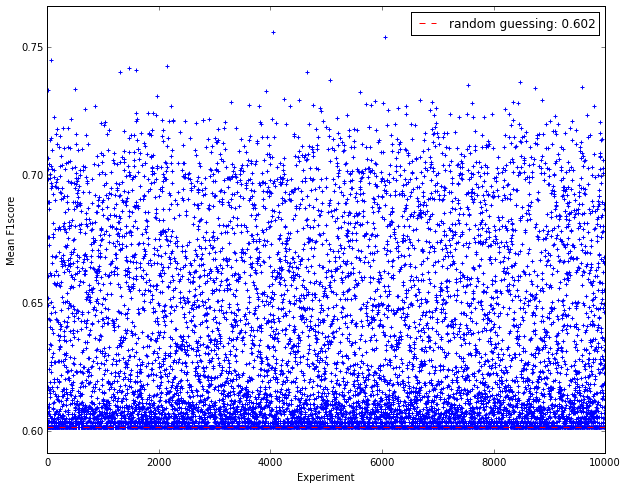

In [427]:
plt.figure(figsize=[10, 8])
plt.xlim([0, N])
plt.ylim([rand_F1scores.min()-0.01, max(rand_F1scores.max(), randF1)+0.01])
plt.xlabel('Experiment')
plt.ylabel('Mean F1score')
plt.plot([0, N], [randF1, randF1], color='r', linestyle='--', label='random guessing: ' + str(round(randF1,3)))
plt.scatter([range(N)], rand_F1scores, marker='+')
plt.legend()

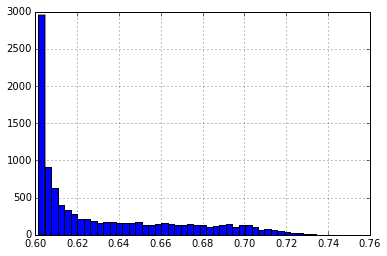

In [406]:
pd.Series(rand_F1scores).hist(bins=50)

<a id='sec4.2'></a>

### 4.2 Experiment with single feature

**NOTE**: 
 * When trajectories in training set can't cover all POIs and/or all types of POI category transitions, all above single feature plots show uniform results, and all points are below the green line (e.g. use Osaka data).
 * For experiment with *single feature*, if the weight of the feature is `0`, then no features are used in the algorithm, and the scores of all candidate trajectories are the same, so the F1 score of the algorithm will depend on the order of candidates (python will choose the first one), as a result, the actual value of F1 score is meaningless, which indicates that `0` should be *skipped* in this case.

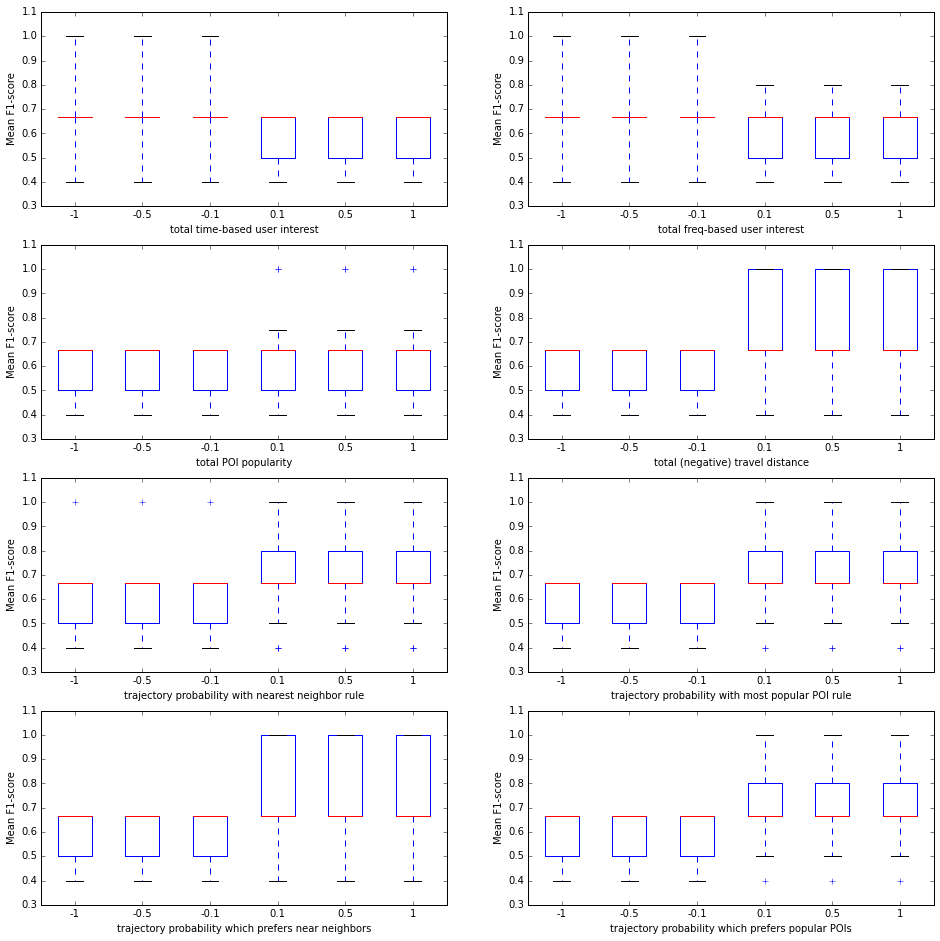

In [407]:
#values = [-0.5, 0, 0.5]
#values = np.linspace(-1, 1, 11)
#values = [-0.1, 0.1]
values = [-1, -0.5, -0.1, 0.1, 0.5, 1]
plt.figure(figsize=[16, 16])
for j in range(nfeatures):
    all_F1scores = []
    for k in range(len(values)):
        weights = np.zeros(nfeatures, dtype=np.float64)
        weights[j] = values[k]
        all_scores = features_mat.dot(weights)
        F1scores = []
        for seqid in train_set:
            scores = np.array([all_scores[x] for x in score_indices[seqid]])
            bestseq = enum_seqs[seqid][scores.argmax()]
            F1scores.append(calc_F1score(train_seqs[seqid], bestseq))
        all_F1scores.append(F1scores)
    plt.subplot(4, 2, j+1)
    xlim = [min(values)-0.1, max(values)+0.1]
    ylim = [0.3, 1.1]
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(features_name[j])
    plt.ylabel('Mean F1-score')
    plt.boxplot(all_F1scores, labels=values) #OK
    avgF1scores = np.array([np.mean(x) for x in all_F1scores])
    #plt.scatter(values, avgF1scores, marker='+')
    #plt.plot([values[avgF1scores.argmax()]], [avgF1scores.max()], marker='o', color='r', \
    #                  label='max: ' + str(round(avgF1scores.max(),3)))
    #plt.plot(xlim, [randF1, randF1], color='g', linestyle='--', label='random guessing: ' + str(round(randF1,3)))
    #plt.legend()

#### 4.2.1 Observations with single feature

The *first* feature is the total time-based user interest in a trajectory.  
(i.e sum of (expected time the user spent at each POI)/(average time a user spent at each POI))
It seems the existance of this feature *negative* affected the algorithm, 
which is strange as the IJCAI paper argues that capturing the expected time a user spent at POI will improve the accuracy of trajectory recommendation.

The *second* feature is the total number of visit (of the user) of all POIs in a trajectory.
Similar to the *first* feature, it seems the existance of this feature negative affected the algorithm, 
which is also strange as experiments from the IJCAI paper show that capturing a user's visiting frequency of POI will improve the accuracy of trajectory recommendation, though less than capturing visit time duration, but still much better than greedy and random selection strategies.

The *third* feature is the total POI popularity (i.e. # of visit of a POI by all users) of all POIs in a trajectory.
It seems that doesn't affect the recommendation much, though a positive weight of this feature will help the recommendation algorithm slightly.

The *fourth* feature is the negative (i.e. multiple -1) of total travelling cost (i.e. total travel distance in the trajectory) for a user of a trajectory.
It's strange that the algorithm prefers long travelling distance.

The *fifth* feature is the probability of a recommended trajectory based on the transition probabilities between POI categories and the nearest neighbor rule for choosing a specific POI within a certain category.
It's clear the algorithm likes nearest neighbors.

The *sixth* feature is the probability of a recommended trajectory based on the transition probabilities between POI categories and the most popular POI rule for choosing a specific POI within a certain category. It's clear the algorithm likes popular POIs.

The *seventh* feature is the probability of a recommended trajectory based on the transition probabilities between POI categories and a rule below for choosing a specific POI within a certain category.  
*Rule: choose a random POI with probability proportional to the reciprocal of its distance to current POI.*  
Similar to the *fifth* feature which utilises the nearest neighbor rule, the algorithm doesn't like far neighbors.

The *last* feature is the probability of a recommended trajectory based on the transition probabilities between POI categories and a rule below for choosing a specific POI within a certain category.  
*Rule: choose a random POI with probability proportional to its popularity.*  
Similar to the *sixth* feature which utilises the most popular POI rule, the algorithm doesn't like non-popular POIs. 

<a id='sec4.3'></a>

### 4.3 Search weights using coordinate-wise grid search

In [408]:
weights = np.array([0.01, -0.01, 0, 0.88, -0.01, 0.01, -0.05, 0.05])
calc_mean_F1score(train_set, train_seqs, enum_seqs, features_mat.dot(weights), score_indices)

0.7993489583333333

In [409]:
# uniform

# 0.714, [-1.    0.    0.    0.85  0.64 -0.05  0.03  0.]
#weights = np.zeros(nfeatures, dtype=np.float64)

# 0.728, [-0.3   0.65 -0.37  0.99  1.    0.05  0.95  1.]
#weights = np.ones(nfeatures, dtype=np.float64)

# 0.694, [-1.   -1.   -1.    0.22  0.99  0.49  0.25  0.76]
#weights = -1 * np.ones(nfeatures, dtype=np.float64)

# random

# 0.723, [-0.74  0.09 -0.19  0.99  0.84 -0.04  0.03  0.45]
#weights = np.random.uniform(-1, 1, nfeatures)

# 0.753, [0.35 -0.34 -0.17  0.86  0.78  0.35  0.89  0.63]
#weights = rand_weights[ rand_F1scores.argmax() ]

# hints from single feature experiment

# 0.732, [1 -1  1  1  1  1  1 -1]
#weights = np.array([-1, -1, 1, 1, 1, 1, 1, 1])

# 0.756, [0.12 -0.1  -0.03  0.75  0.1   0.1   0.1   0.1]
#weights = np.array([-0.1, -0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

# 0.7996, [0.06 -0.05 -0.01  0.98 -0.02  0.04  0.23  0.43]
#weights = np.array([-0.05, -0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
#weights = np.array([0.06, -0.05, -0.01, 0.98, -0.02, 0.04, 0.23, 0.43]) # init: 0.7996, end: 0.803
#weights = np.array([0.05, -0.05, -0.01, 0.86, -0.02, 0.03, 0.16, 0.43]) # init: 0.803, end: 0.805
#weights = np.array([0.05, -0.05, -0.01, 0.97, -0.02, 0.03, 0.16, 0.36]) # init: 0.805, end: 0.805

# 0.808, [0.02 -0.01  0.01  0.92 -0.02  0.01  0.28 -0.19]
#weights = np.array([-0.02, -0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02])
#weights = np.array([0.02, -0.01, 0.01, 0.92, -0.02, 0.01, 0.28, -0.19]) # init: 0.808, end: 0.810
weights = np.array([0.02, -0.01, 0, 0.87, -0.02, 0.01, 0.37, -0.19]) # init: 0.810, end: 0.810

# 0.810             [0.02, -0.01, 0.01, 0.87, -0.02, 0.01, 0.37, -0.19]
#weights = np.array([0.02, -0.01, 0,    1,    -0.02, 0.01, 0.37, -0.19])

# 0.794, [0.01, -0.01, 0.01, 0.45, -0.01, 0.02, 0.07, 0.01]
#weights = np.array([-0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

# 0.794, [0.01 -0.01  0.01  0.45 -0.01  0.02  0.07  0.01]
#weights = np.array([-0.01, -0.01, 0, 0.01, 0.01, 0.01, 0.01, 0.01])
#weights = np.array([0.01, -0.01, 0.01, 0.45, -0.01, 0.02, 0.07, 0.01]) # init: 0.794, end: 0.795
#weights = np.array([0.02, -0.01, 0, 0.44, -0.01, 0.02, 0.07, 0.01]) # init: 0.795, end: 0.795

In [410]:
#params = np.linspace(-1, 1, 41)
#params = np.linspace(-1, 1, 101)
params = np.linspace(-1, 1, 201)
F1scores = np.zeros((weights.shape[0], params.shape[0]), dtype=np.float64)

In [411]:
t1 = datetime.now()
for k in range(nfeatures):    
    for j in range(params.shape[0]):
        weights[k] = params[j]
        all_scores = features_mat.dot(weights)
        F1scores[k, j] = calc_mean_F1score(train_set, train_seqs, enum_seqs, all_scores, score_indices)
    maxidx = F1scores[k].argmax()
    weights[k] = params[maxidx]
t2 = datetime.now()
print('%d seconds used' % (t2-t1).total_seconds()) # 120 seconds

119 seconds used


In [412]:
#t1 = datetime.now()
#for k in range(nfeatures):
#    all_weights = np.matlib.repmat(weights, params.shape[0], 1)
#    for j in range(params.shape[0]):
#        all_weights[j, k] = params[j]
#    F1scores1 = Parallel(n_jobs=-2)\
#                        (delayed(calc_mean_F1score)
#                         (train_set, train_seqs, enum_seqs, features_mat.dot(all_weights[j]), score_indices)
#                         for j in range(params.shape[0]))
#    F1scores[k] = np.array(F1scores1)       
#    maxidx = F1scores[k].argmax()
#    weights[k] = params[maxidx]
#t2 = datetime.now()
#print('%d seconds used' % (t2-t1).total_seconds()) # 407 seconds

In [413]:
print(weights)
print(F1scores[-1].max())

[ 0.02 -0.01  0.    0.87 -0.02  0.01  0.37 -0.19]
0.810416666667


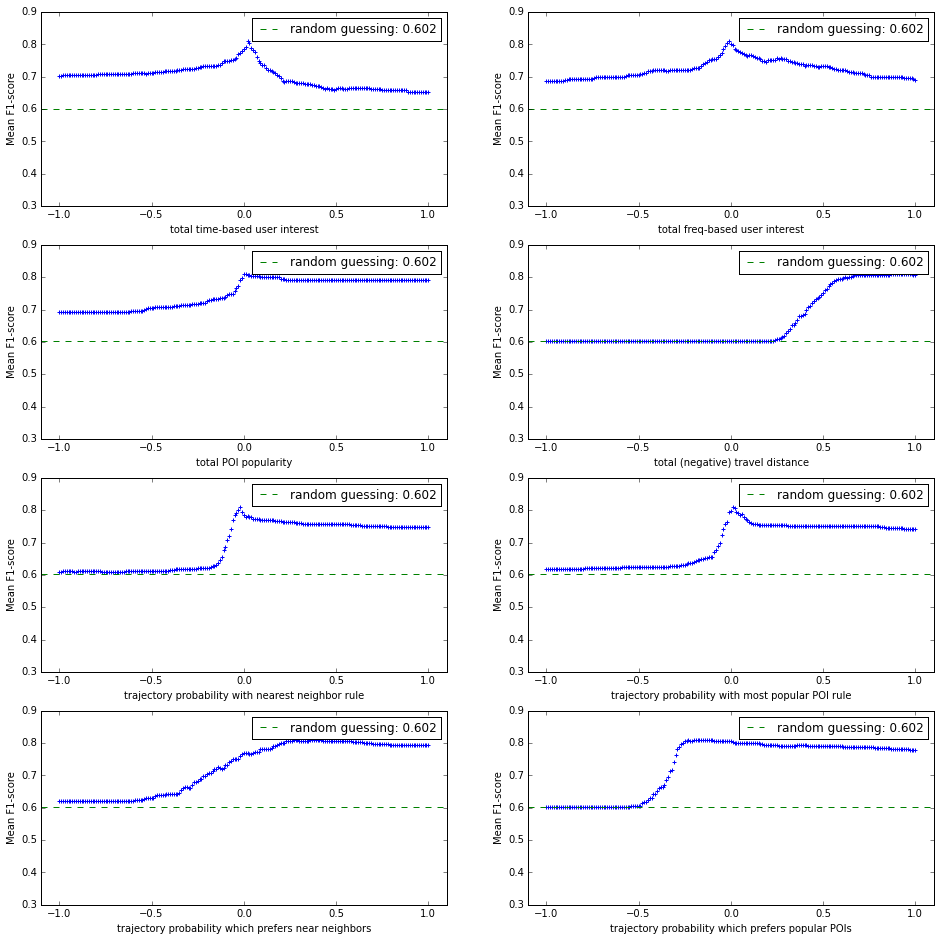

In [414]:
plt.figure(figsize=[16, 16])
for k in range(nfeatures):
    plt.subplot(4, 2, k+1)
    plt.xlim([-1.1, 1.1])
    plt.ylim([0.3, 0.9])
    plt.xlabel(features_name[k])
    plt.ylabel('Mean F1-score')
    plt.scatter(params, F1scores[k], marker='+')
    plt.plot([-1.1, 1.1], [randF1, randF1], color='g', linestyle='--', label='random guessing: ' + str(round(randF1,3)))
    plt.legend()

<a id='sec5'></a>

## 5. Apply search results to testing set

In [415]:
enum_seqs_test, test_seqs = enum_345_seq(test_set, poi_list)

Load features from file if possible.

In [416]:
doCompute = True

In [417]:
test_set1 = pickle.load(open(ftest, 'rb'))
if (np.array(sorted(test_set1))  == np.array(sorted(test_set))).all() and os.path.exists(ffeatures_test):
    doCompute = False

In [418]:
all_features_test = None

In [419]:
if doCompute:
    #[(seqid, seqidx_in_enum_seqs_dict)]
    seq_info_test = [(seqid, j) for seqid in test_set for j in range(len(enum_seqs_test[seqid]))]
    # all CPUs but one are used
    all_features_test = Parallel\
                        (n_jobs=-2)\
                        (delayed\
                        (calc_features)\
                        (seq_user.loc[x[0]].iloc[0], enum_seqs_test[x[0]][x[1]], poi_all, user_interest, \
                         log10_trans_mat, poi_dist_mat, poi_rdist_mat) \
                        for x in seq_info_test)
    pickle.dump(all_features_test, open(ffeatures_test, 'wb'))
else:
    # load features
    all_features_test = pickle.load(open(ffeatures_test, 'rb')) 

In [420]:
print(len(all_features_test))

76599


In [421]:
score_indices_test = dict() # score vector index in the feature matrix
num_enum_seq_test = 0

In [422]:
for seqid in test_set:
    num = len(enum_seqs_test[seqid])
    score_indices_test[seqid] = [x for x in range(num_enum_seq_test, num_enum_seq_test + num)]
    num_enum_seq_test += num

In [423]:
print(num_enum_seq_test)

76599


In [424]:
assert(len(all_features_test) == num_enum_seq_test)

In [425]:
features_mat_test = np.array(all_features_test)
print(features_mat_test.shape)

(76599, 8)


In [426]:
weights = np.array([0.01, -0.01, 0, 0.88, -0.01, 0.01, -0.05, 0.05]) # train: 0.7993, test: 0.75040650406504061
#weights = np.array([0.02, -0.01, 0, 0.87, -0.02, 0.01, 0.37, -0.19]) # train: 0.810, test: 0.744
#weights = np.array([0.02, -0.01, 0.01, 0.92, -0.02, 0.01, 0.28, -0.19]) # train: 0.808, test: 0.744
#weights = np.array([0.05, -0.05, -0.01, 0.97, -0.02, 0.03, 0.16, 0.36]) # train: 0.805, test: 0.732
#weights = np.array([0.06, -0.05, -0.01, 0.98, -0.02, 0.04, 0.23, 0.43]) # train: 0.7996, test: 0.732
#weights = np.array([0.02, -0.01, 0, 0.44, -0.01, 0.02, 0.07, 0.01]) # init: 0.795, test: 0.740
calc_mean_F1score(test_set, test_seqs, enum_seqs_test, features_mat_test.dot(weights), score_indices_test)

0.75040650406504061